## Initialization

<b>Sprint 15, Age Verification, by Deborah Thomas</b>

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage.

- The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
- Computer vision methods can be used to determine age of a person from a photo
- The task then is to build and evaluate a model for verifying people's age

The goal of the project is to create a model that will predict the age of a customer during the checkout process.

# Import Libraries

In [26]:
import pandas as pd

import os
from PIL import Image 
import random

import tensorflow as tf

import matplotlib.pyplot as plt 
import inspect

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam

## Load Data

In [28]:
#!cp /datasets/faces/labels.csv ./

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [34]:
labels = pd.read_csv('../datasets/labels.csv')
labels.shape

(133935, 5)

In [42]:
# preprocessing, to normalize the data
datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)

## EDA

In [45]:
labels.describe()

,real_age,apparent_age,worker_age
count,133935.000000,133935.000000,1.339350e+05
mean,29.131295,29.040691,7.208132e+01
std,15.623277,15.045521,1.540825e+04
min,1.000000,0.000000,-1.000000e+00
25%,19.000000,20.000000,2.000000e+01
50%,27.000000,27.000000,2.900000e+01
75%,38.000000,37.000000,4.100000e+01
max,100.000000,100.000000,5.638976e+06


- There are 7591 files.
- The youngest age is 20. The oldest age is 100. The average age is 31.2. The majority of customers are 41 years or younger.

In [48]:
labels.columns

Index(['file_name', 'real_age', 'apparent_age', 'worker_age', 'worker_gender'], dtype='object')

In [50]:
display(labels)

,file_name,real_age,apparent_age,worker_age,worker_gender
0,000000.jpg,4,5,36,male
1,000000.jpg,4,4,38,female
2,000000.jpg,4,7,52,female
3,000000.jpg,4,5,50,male
4,000000.jpg,4,4,52,female
...,...,...,...,...,...
133930,004112.jpg,20,17,-1,NaN
133931,004112.jpg,20,20,26,NaN
133932,004112.jpg,20,22,31,NaN
133933,004112.jpg,20,19,19,NaN


<b>Print out a few random images.</b>

In [53]:
def display_images_by_age(labels, image_dir, num_images=15):
    # Load unique ages
    unique_ages = labels['real_age'].unique()
    
    # Create a figure to display images
    plt.figure(figsize=(15, 10))
    count = 0
    
    # Randomly select images for display
    for age in unique_ages:
        age_group = labels[labels['real_age'] == age]  # Filter by age
    
        if not age_group.empty:
            selected_image = random.choice(age_group['file_name'].tolist())
            img_path = os.path.join(image_dir, selected_image) 
            img = plt.imread(img_path) 
            
            # Plotting
            plt.subplot(5, 5, count + 1)  # Adjust subplot grid size if needed
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Age: {age}')
            count += 1
            
            # Stop when enough images are displayed
            if count >= num_images:  # Stop when enough images are displayed
                break
                
    plt.tight_layout()
    plt.show()

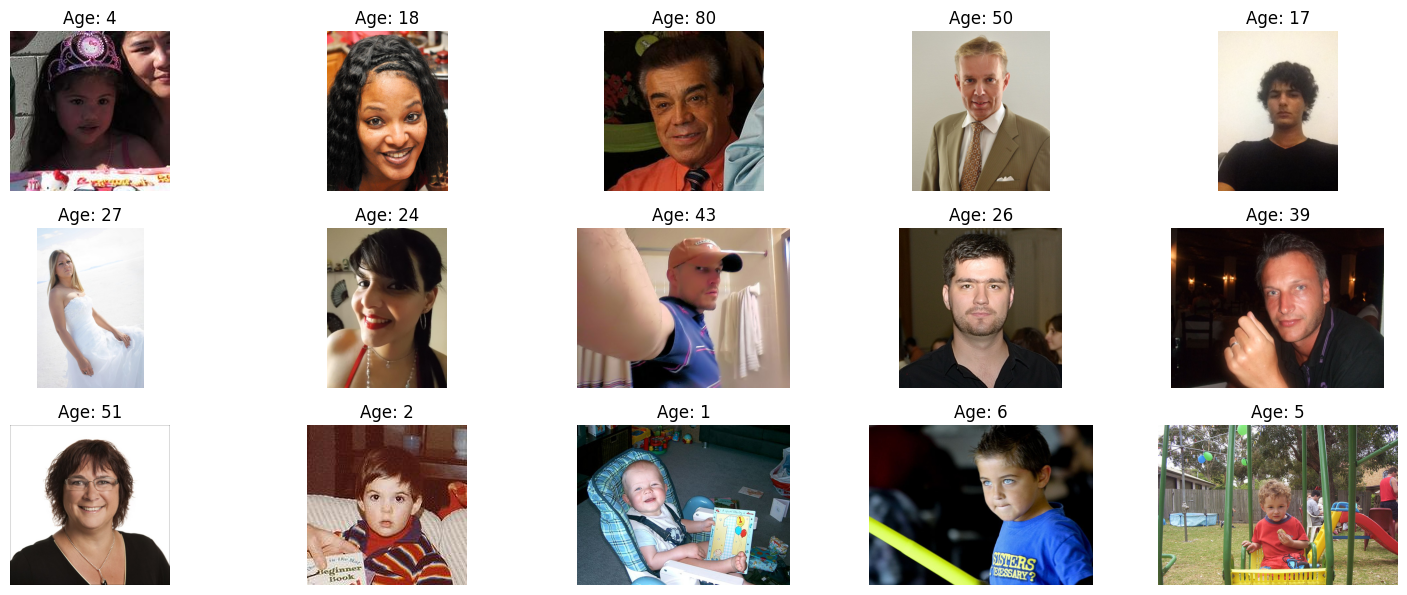

In [59]:
#Call the function, to display images
display_images_by_age(labels, '../datasets/faces/train/', num_images=15)

Many of 15, of the randomly chosen images, are people under the age of 21.

<b>Look at age distribution:</b>

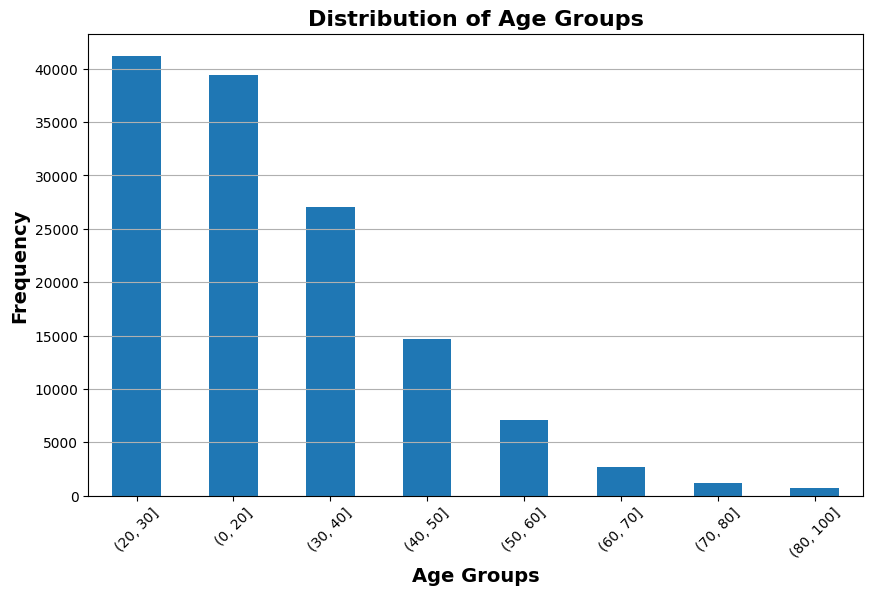

In [64]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]  # Define the bins
labels['age_group'] = pd.cut(labels['real_age'], bins)

plt.figure(figsize=(10, 6))
labels['age_group'].value_counts().plot(kind='bar')
plt.title('Distribution of Age Groups', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Age Groups', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

### Findings

More than half of the customers fall within the age range of 0-30, with the largest age group being 20-30. The next biggest age group is ages 0-20. The smallest age group is 80-100.

In [68]:
count_under_21 = (labels['real_age'] < 21).sum()
print(f"The number of customers under 21 is: {count_under_21}")

The number of customers under 21 is: 39373


In [70]:
percentage = round((count_under_21 / len(labels)) * 100, 2)
print(f"{percentage} percent of the customers, in this dataset, are under the drinking age.")

29.4 percent of the customers, in this dataset, are under the drinking age.


## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [78]:
!ls ../datasets/faces/train/ | tail -10

004109.jpg_face.jpg
004110.jpg
004110.jpg.mat
004110.jpg_face.jpg
004111.jpg
004111.jpg.mat
004111.jpg_face.jpg
004112.jpg
004112.jpg.mat
004112.jpg_face.jpg


In [80]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
    datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
    
        #X represents the input features (images)
        x_col='file_name',
    
        #Y represents the target values (ages)
        y_col='real_age',
    
        target_size=(224, 224),
        batch_size=128,
        class_mode='raw',
        seed=12345)

    return train_gen_flow

In [82]:
def load_test(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
    datagen = ImageDataGenerator(rescale=1./255)
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        
        directory='/datasets/faces/final_files/',
    
        #X represents the input features (images)
        x_col='file_name',
    
        #Y represents the target values (ages)
        y_col='real_age',
    
        target_size=(224, 224),
        batch_size=128,
        class_mode='raw',
        seed=12345)

    return test_gen_flow
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # place your code here
    val_datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/final_files/',
    target_size=(150,150),
    batch_size=32,
    class_mode='other',
    subset='validation',
    seed=12345,
)

    return test_gen_flow

In [84]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # place your code here
    model = Sequential()
    
    #model.add(Input(shape=input_shape))
    
    model.add(
    Conv2D(
        6, (5, 5), padding='same', activation='tanh', input_shape=input_shape)
    )
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    #64 neurons
    model.add(Dense(64, activation='tanh'))
    
    #1 neuron
    model.add(Dense(1, activation='linear'))
    
    # Compile the model with the custom optimizer
    model.compile(optimizer='adam', loss='mean_squared_error', learning_rate=0.002)
    
    return model

In [86]:
def train_model(model, train_data, test_data, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_data,
        validation_steps=validation_steps
    )
    
    
    # Make predictions on the test data
    test_predictions = model.predict(test_data)
    test_labels = test_data.labels  # Assuming 'classes' contains ages
    
    # Calculate MSE
    mse = mean_squared_error(test_labels, test_predictions)
    
    # Print the MSE score
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    
    return model


### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [10]:
import inspect
# Initialize the string for the script
init_str = """\
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU device found and configured')
else:
    print('No GPU devices found, using CPU')
"""

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
        
    # Add main execution block
    f.write("""

if __name__ == '__main__':
    train_data = load_train('../datasets/faces/train')
    test_data = load_test('../datasets/faces/test')
    model = create_model((224, 224, 3))
    trained_model = train_model(model, train_data, test_data, epochs=20, batch_size=64)
""")
print("Script 'run_model_on_gpu.py' has been created.")

Script 'run_model_on_gpu.py' has been created.


### Output

<b>Before changing up the parameters:</b>

This command was kicked off at a shell:
    
python run_model_on_gpu.py

Here is the output from that:

In [ ]:
238/238 [==============================] - 446s 2s/step - loss: 294.0237 - val_loss: 293.9236
Epoch 9/20
238/238 [==============================] - 449s 2s/step - loss: 293.9405 - val_loss: 293.9818
Epoch 10/20
238/238 [==============================] - 437s 2s/step - loss: 294.0166 - val_loss: 293.9278
Epoch 11/20
238/238 [==============================] - 425s 2s/step - loss: 294.0671 - val_loss: 293.9392
Epoch 12/20
238/238 [==============================] - 426s 2s/step - loss: 294.0429 - val_loss: 294.1617
Epoch 13/20
238/238 [==============================] - 426s 2s/step - loss: 294.0032 - val_loss: 294.1418
Epoch 14/20
238/238 [==============================] - 431s 2s/step - loss: 294.0378 - val_loss: 293.9498
Epoch 15/20
238/238 [==============================] - 421s 2s/step - loss: 293.9728 - val_loss: 293.9676
Epoch 16/20
238/238 [==============================] - 422s 2s/step - loss: 294.0523 - val_loss: 293.9202
Epoch 17/20
238/238 [==============================] - 423s 2s/step - loss: 294.0379 - val_loss: 293.9186
Epoch 18/20
238/238 [==============================] - 420s 2s/step - loss: 294.0869 - val_loss: 293.9149
Epoch 19/20
238/238 [==============================] - 419s 2s/step - loss: 294.0520 - val_loss: 294.0109
Epoch 20/20
238/238 [==============================] - 419s 2s/step - loss: 294.1677 - val_loss: 293.9876
(python3) jovyan@jupyter-user-3-3c910a2a-af01-4aff-9aaf-c1ae28de4ca2:~/work$

<b>Here is the output from the GPU platform
https://colab.research.google.com:</b>

In [ ]:
GPU device found and configured
Found 133935 validated image filenames.
Found 133935 validated image filenames.
Epoch 1/20
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 2912s 3s/step - loss: 379.9568 - val_loss: 244.0849
Epoch 2/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - loss: 245.2066

I ran out of free time, on Colab, because I do not pay for a membership, so it would not render further.

I used the T4 CPU to render.

## Conclusions

Running locally is slower than running externally.
Loss is not increasing after 10 epochs.
There were a lot of technical glitches, while working on this project, such as when I download the test, train, valid folders, they do not match the naming of the instructions, however, as for the actually coding, this was easier than I expected that it would be to determine ages of people.